## **Exercise 4:** Chest Pathologies

Implement a CNN using TensorFlow to perform multi-label classification on the NIH Chest X-ray14 dataset — a medical imaging dataset containing over 112,000 chest X-ray images labeled with up to 14 thoracic diseases per image (e.g., pneumonia, cardiomegaly, edema, fibrosis). Download and store the dataset locally (available at [NIH Clinical Center](https://nihcc.app.box.com/v/ChestXray-NIHCC)) and load image paths and labels from the provided Data_Entry_2017.csv file. Use tf.data.Dataset.from_tensor_slices to build a high-performance pipeline that loads, decodes, and preprocesses the images (resizing, contrast enhancement, normalization), and one-hot encodes the multi-label disease tags. Due to the high resolution and size of the dataset, use efficient caching and prefetching. Implement a CNN capable of learning from noisy, imbalanced, multi-label data—ideally using or fine-tuning a pre-trained architecture like DenseNet121 or EfficientNet. Use sigmoid activation in the output layer and binary cross-entropy as the loss function. Evaluate the model using AUC, precision, and recall per label. This time, consider that you're detecting the presence of one or multiple pathologies present in each image, meaning that you'll be working on a multiclass, multilabel predictor model.

In [9]:
!tar -xzvf images_001.tar.gz -C /content/images


images/00001075_000.png
images/00001151_006.png
images/00000583_047.png
images/00000830_002.png
images/00001232_004.png
images/00000245_001.png
images/00000089_000.png
images/00000911_000.png
images/00000811_000.png
images/00001213_002.png
images/00001057_001.png
images/00000949_004.png
images/00000869_009.png
images/00000731_005.png
images/00000121_007.png
images/00001088_021.png
images/00000631_005.png
images/00000116_015.png
images/00000459_053.png
images/00001286_001.png
images/00000556_002.png
images/00000308_000.png
images/00000127_002.png
images/00000047_007.png
images/00000637_000.png
images/00001039_002.png
images/00000208_000.png
images/00000376_007.png
images/00000103_008.png
images/00000966_000.png
images/00000785_002.png
images/00001187_004.png
images/00000537_000.png
images/00000063_000.png
images/00000866_000.png
images/00001268_002.png
images/00001301_040.png
images/00000538_003.png
images/00000492_000.png
images/00000246_018.png
images/00000109_003.png
images/00000392_

In [32]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
CSV_PATH = "/content/Data_Entry_2017_v2020.csv"  # Ruta al archivo CSV
IMAGE_DIR = "/content/images"  # Carpeta donde están las imágenes descomprimidas


In [33]:
# Cargar CSV
df = pd.read_csv(CSV_PATH)

# Agregar columna con ruta completa a cada imagen
df['path'] = df['Image Index'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# Filtrar solo archivos que existen
df = df[df['path'].apply(os.path.exists)].reset_index(drop=True)

print(f"Imágenes encontradas: {len(df)}")


Imágenes encontradas: 123


In [34]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False

# Filtrar imágenes válidas (puede tardar unos segundos)
df = df[df['path'].apply(is_valid_image)].reset_index(drop=True)
print(f"Imágenes válidas: {len(df)}")


Imágenes válidas: 122


In [35]:
# Obtener todas las clases únicas
all_labels = sorted(set('|'.join(df['Finding Labels'].unique()).split('|')))
print(f"Etiquetas: {all_labels}")

# Codificar etiquetas
def encode_labels(label_string):
    labels = label_string.split('|')
    return [1 if label in labels else 0 for label in all_labels]

df['encoded_labels'] = df['Finding Labels'].apply(encode_labels)


Etiquetas: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']


In [36]:
# Función para cargar y preprocesar imágenes robustamente
def process_path(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.resize(img, [224, 224])
    img = tf.image.per_image_standardization(img)
    return img, label

# Crear datasets
paths = df['path'].values
labels = tf.constant(df['encoded_labels'].tolist(), dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(500).batch(32).cache().prefetch(tf.data.AUTOTUNE)

# Separar en entrenamiento y validación
train_size = int(0.8 * len(df))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)


In [37]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# DenseNet sin pesos preentrenados (blanco y negro)
base_model = DenseNet121(include_top=False, input_shape=(224, 224, 1), weights=None)

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(len(all_labels), activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


In [38]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 283s 37s/step - accuracy: 0.2441 - auc: 0.6088 - loss: 0.5273
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.5045 - auc: 0.8385 - loss: 0.2394
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.5116 - auc: 0.8817 - loss: 0.2154
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.5381 - auc: 0.9032 - loss: 0.1957
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.6370 - auc: 0.9286 - loss: 0.1697
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.7220 - auc: 0.9598 - loss: 0.1357
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.6858 - auc: 0.9643 - loss: 0.1348
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.7021 - auc: 0.9656 - loss: 0.1314
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.7573 - auc: 0.9850 - loss: 0.0986
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.8200 - auc: 0.9907 - loss: 0.0833


In [49]:
# Dividir antes de mapear
train_paths = paths[:train_size]
train_labels = labels[:train_size]

val_paths = paths[train_size:]
val_labels = labels[train_size:]

# Crear datasets separados
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(500).batch(32).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)


In [50]:
y_true = []
y_pred = []

for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images)
    y_true.append(batch_labels.numpy())
    y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
y_pred_bin = (y_pred > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("Métricas por etiqueta:\n")
for i, label in enumerate(all_labels):
    y_true_i = y_true[:, i]
    y_pred_i = y_pred_bin[:, i]

    try:
        auc = roc_auc_score(y_true_i, y_pred[:, i])
    except ValueError:
        auc = 0.0

    precision = precision_score(y_true_i, y_pred_i, zero_division=0)
    recall = recall_score(y_true_i, y_pred_i, zero_division=0)
    f1 = f1_score(y_true_i, y_pred_i, zero_division=0)

    print(f"{label:<20} Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")


Métricas por etiqueta:

Atelectasis          Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.595
Cardiomegaly         Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: nan
Consolidation        Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.500
Edema                Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.875
Effusion             Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.717
Emphysema            Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.958
Fibrosis             Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: nan
Infiltration         Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.420
Mass                 Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: nan
No Finding           Precision: 0.400 | Recall: 1.000 | F1: 0.571 | AUC: 0.480
Nodule               Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Pleural_Thickening   Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: nan
Pneumothorax         Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: nan


In [52]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images)
    y_true.append(batch_labels.numpy())
    y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
y_pred_bin = (y_pred > 0.5).astype(int)

# Inicializar métricas
metrics = {
    "label": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc": []
}

# Calcular métricas por etiqueta
for i, label in enumerate(all_labels):
    y_t = y_true[:, i]
    y_p = y_pred_bin[:, i]

    try:
        auc = roc_auc_score(y_t, y_pred[:, i])
    except ValueError:
        auc = 0.0

    precision = precision_score(y_t, y_p, zero_division=0)
    recall = recall_score(y_t, y_p, zero_division=0)
    f1 = f1_score(y_t, y_p, zero_division=0)

    metrics["label"].append(label)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)
    metrics["auc"].append(auc)

# Mostrar tabla resumen
import pandas as pd
df_metrics = pd.DataFrame(metrics)
display(df_metrics.round(3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,label,precision,recall,f1_score,auc
0,Atelectasis,0.0,0.0,0.000,0.595
1,Cardiomegaly,0.0,0.0,0.000,NaN
2,Consolidation,0.0,0.0,0.000,0.500
3,Edema,0.0,0.0,0.000,0.875
4,Effusion,0.0,0.0,0.000,0.717
5,Emphysema,0.0,0.0,0.000,0.958
6,Fibrosis,0.0,0.0,0.000,NaN
7,Infiltration,0.0,0.0,0.000,0.420
8,Mass,0.0,0.0,0.000,NaN
9,No Finding,0.4,1.0,0.571,0.480


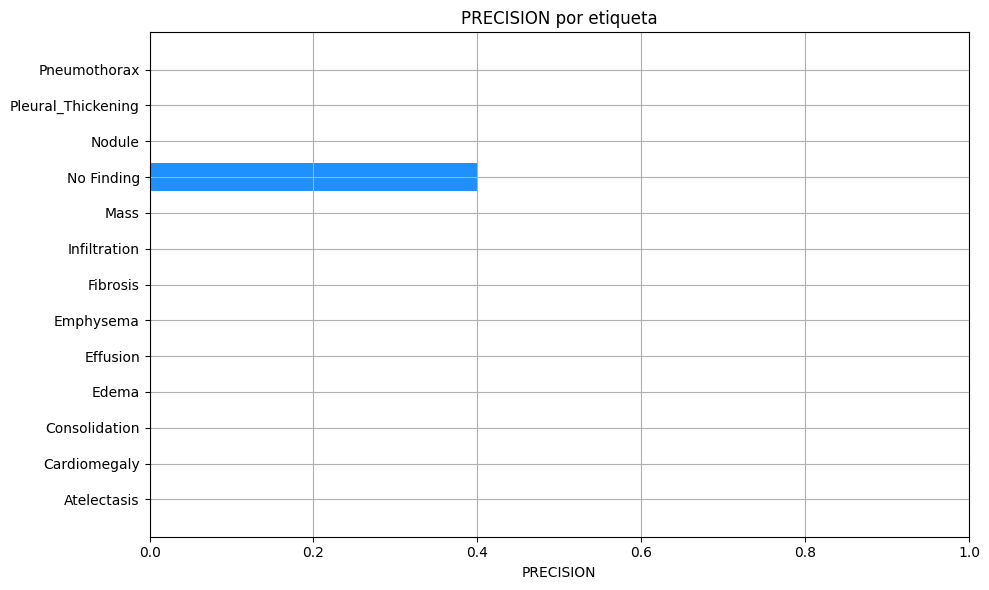

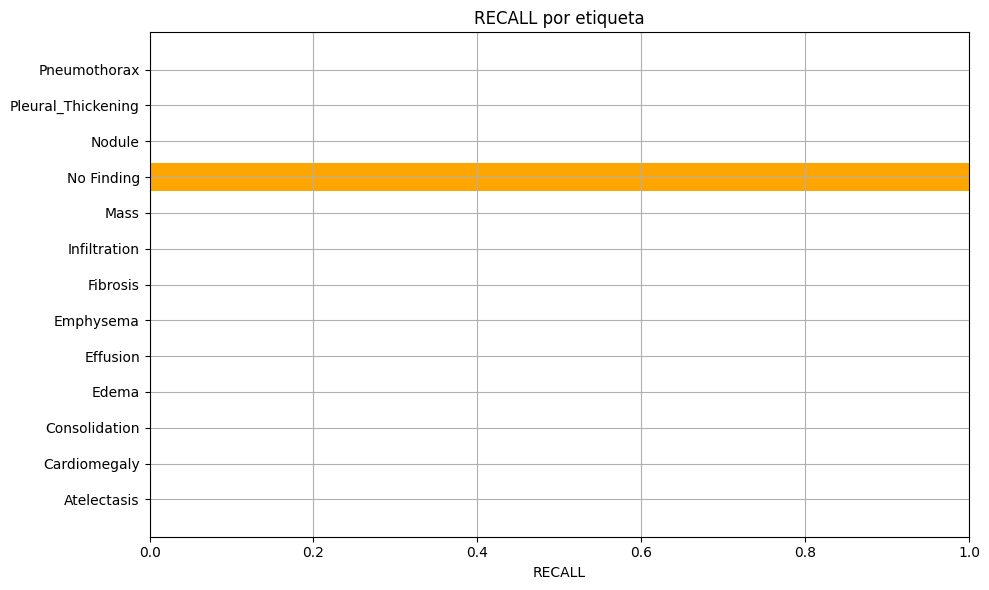

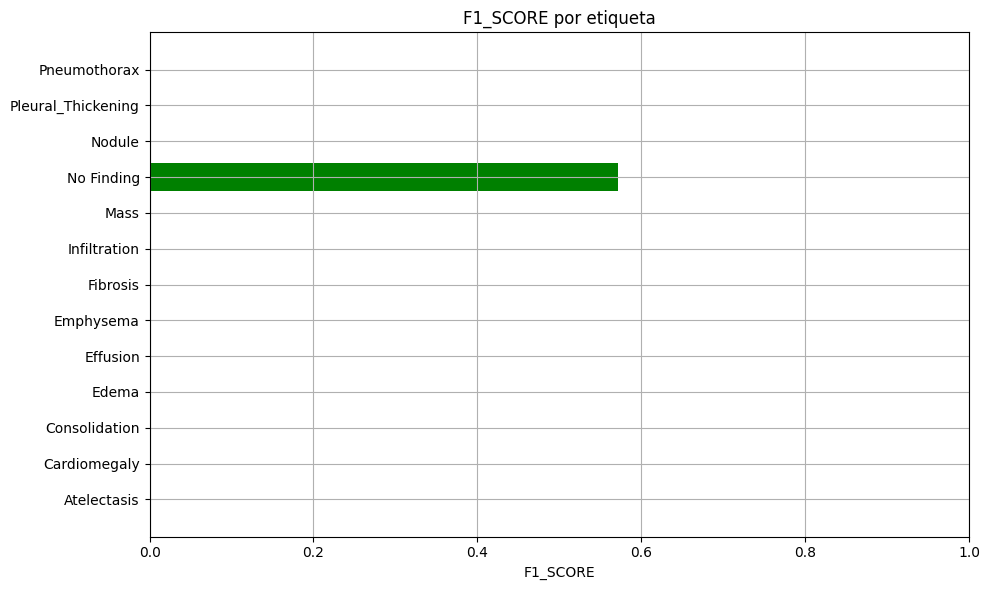

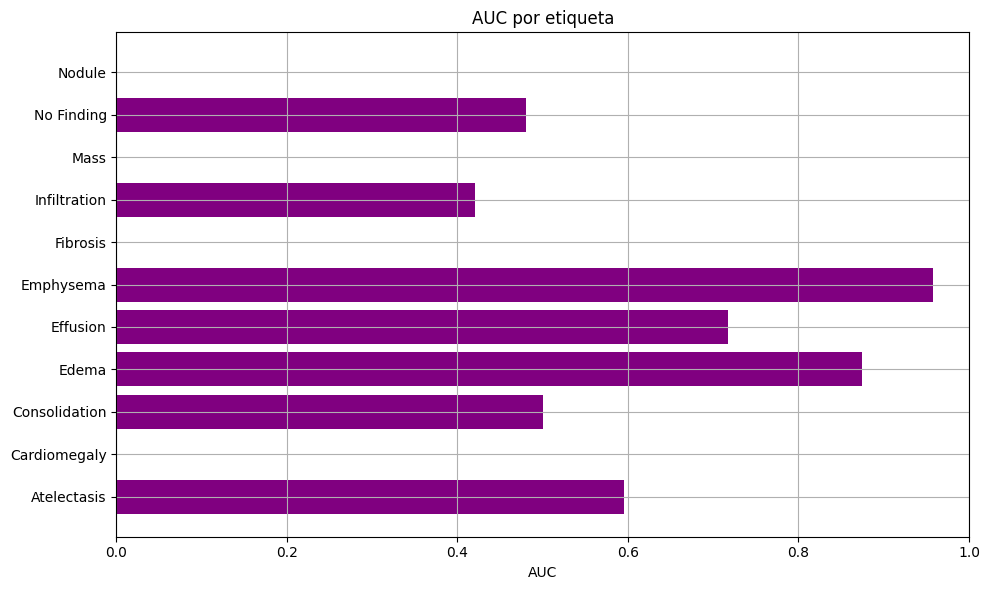

In [53]:
def plot_metric(df, metric_name, color='skyblue'):
    plt.figure(figsize=(10, 6))
    plt.barh(df["label"], df[metric_name], color=color)
    plt.title(f"{metric_name.upper()} por etiqueta")
    plt.xlabel(metric_name.upper())
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Graficar todas las métricas principales
plot_metric(df_metrics, "precision", "dodgerblue")
plot_metric(df_metrics, "recall", "orange")
plot_metric(df_metrics, "f1_score", "green")
plot_metric(df_metrics, "auc", "purple")
